In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import behav_annotation
from dlc_utils import *
from behav_annotation import Behav
from BehavPreprocess import BehavPreprocess
from DimReduction import DimReduction
from Segmentation import Segmentation
from get_results_util import store_results

def fix_layout(width:int=90): 
    from IPython.core.display import display, HTML 
    display(HTML("<style>.container { width:" + str(width) + "% !important; }</style>")) 

fix_layout()
start_time = time.time()

ModuleNotFoundError: No module named 'torch'

# Reading Data & Preprocessing

In [ ]:
mice_id = find_videos(r'C:\Users\jhflc\Documents\Projects\KI_article', extension='.pkl')
print(mice_id)
#vid_paths = get_paths(['blackfly_375529_2021-07-25_7_VIDEO.avi'],r'C:\Users\jhflc\Documents\Projects\KI_article\data')
#print(vid_paths)

In [2]:
# Get dictionary with every recording and info
root_dir = '/Users/joaohenrique/Documents/Clusterolo/NEVARO_behavior/muse_recordings'
print(patient_files(root_dir))

# Select recordings of interest
file_names = ['EEG_recording_2021-09-09-09.52.29.csv', 'EEG_recording_2021-07-06-13.21.58.csv']
eeg_paths = get_paths(file_names, root_dir)
print(eeg_paths)

{'RITA': {'2021_09_09': {'Recording': 'EEG_recording_2021-09-09-09.52.29.csv', 'length': 314713}, '2021_07_09': {'Recording': 'EEG_recording_2021-07-09-15.10.24.csv', 'length': 314783}}, 'CAMPAGNOLO': {'2021_07_09': {'Recording': 'EEG_recording_2021-07-09-18.01.35.csv', 'length': 153083}, '2021_07_06': {'Recording': 'EEG_recording_2021-07-06-13.21.58.csv', 'length': 98994}}, '.ipynb_checkpoints': {}}
['/Users/joaohenrique/Documents/Clusterolo/NEVARO_behavior/muse_recordings/RITA/2021_09_09/EEG_recording_2021-09-09-09.52.29.csv', '/Users/joaohenrique/Documents/Clusterolo/NEVARO_behavior/muse_recordings/CAMPAGNOLO/2021_07_06/EEG_recording_2021-07-06-13.21.58.csv']


In [3]:
train_dataset = BehavPreprocess(eeg_paths, ti=10000, tf=11000, samp_rate=220, min_frequency=3, max_frequency=20, 
                                num_channels=50, bound_len=50, smooth=True, mean_center=True, normalize=True, 
                                no_bounds=True, dump_rest=False)
train_data = train_dataset.preprocess_data
experiment = {'Preprocess':train_dataset.preprocess_dict}

Training directories: ['/Users/joaohenrique/Documents/Clusterolo/NEVARO_behavior/muse_recordings/RITA/2021_09_09/EEG_recording_2021-09-09-09.52.29.csv', '/Users/joaohenrique/Documents/Clusterolo/NEVARO_behavior/muse_recordings/CAMPAGNOLO/2021_07_06/EEG_recording_2021-07-06-13.21.58.csv']
Number of experiments: 2
Total of 0 nan or inf
Smoothing the EEG data with a Savitzky–Golay filter
Mean centering the filtered EEGs
Performing time-frequency analysis
Wavelet center frequencies: [20.         19.24046357 18.50977192 17.80682962 17.13058284 16.48001775
 15.85415906 15.25206849 14.67284341 14.11561546 13.57954925 13.06384114
 12.56771798 12.090436   11.63127967 11.18956064 10.76461669 10.35581077
  9.96252999  9.58418477  9.2202079   8.87005371  8.53319726  8.20913356
  7.89737676  7.59745949  7.30893213  7.03136212  6.76433334  6.50744546
  6.26031336  6.02256656  5.79384863  5.57381667  5.36214083  5.15850377
  4.96260019  4.77413641  4.59282989  4.41840881  4.25061168  4.08918696
  3.9

# Dimensionality Reduction

In [4]:
# Techniques: kernel_PCA=0, t_SNE=1, Par_tsne=2, Par_tsne2=3, Isomap=4, Umap=5, Par_Umap=6, PCA=7 || 2,5&6 NOT WORKING.
low_dim = DimReduction(train_data.copy(), None, technique=1, tsne_perplexity=25, n_iter=1000)
data_embed = low_dim.data_embed
experiment['Embedding'] = low_dim.embedding_dict

Performing t-SNE with parameters: {'n_components': 2, 'perplexity': 25, 'early_exaggeration': 12.0, 'learning_rate': 200.0, 'n_iter': 1000, 'n_iter_without_progress': 100, 'min_grad_norm': 1e-07, 'metric': 'euclidean', 'init': 'random', 'verbose': 0, 'random_state': None, 'method': 'barnes_hut', 'angle': 0.5}
Embedded data shape: (1800, 2)
Dimensionality reduction completed. Time elapsed: 9.614360094070435 seconds


# Segmentation of low dimensional space

In [5]:
# Techniques: Watershed=0, GMM=1, HDBSCAN=2, HAC=3, random=4
clustering = Segmentation(data_embed, technique=3, xmax=1200, ymax=1200, mesh_mag=2)
clust_labels = clustering.clust_labels
experiment['Clustering'] = clustering.clustering_dict

Performing HAC clustering with parameters: {'n_clusters': 125, 'affinity': 'euclidean', 'connectivity': None, 'compute_full_tree': 'auto', 'linkage': 'ward', 'distance_threshold': None, 'compute_distances': False}
Number of clusters: 2
Clustering completed. Time elapsed: 0.12362170219421387 seconds


# Store results 

In [6]:
save_path = store_results(experiment,'/Users/joaohenrique/Documents/Clusterolo/NEVARO_behavior/behav_results',
                          start_time)

# Plot some results (testing)

In [7]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import headband_setup

def plot_EEGs(eeg_list, electrode_names, save_path, samp_rt, file_names,
              experiment=0, file_name='plot', fig_sz=(18,4)):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=fig_sz)
    electrodes = headband_setup.electrode_names()
    colors = pl.cm.viridis(np.linspace(0,1,len(electrodes)))
    for i in range(len(electrodes)):
        ax.plot(eeg_list[experiment][i,:], alpha=1,
                color=colors[i], label=electrodes[i])
    ax.set_xlabel(f'Time instances (fs={samp_rt}Hz)')
    ax.set_ylabel('Voltage')
    ax.set_title(f'EEG plot: {file_names[experiment]}')
    ax.legend()
#     ax.grid()
    plt.savefig(save_path+'/'+file_name+'.png')    
#     plt.show()

def plot_wavelets(wav_exp_list, exp_eeg_list, file_names, electrodes, n_chan, samp_rt, save_path,
                  experiment=0, fig_sz=(12,12), file_name='wavelets_plot'):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=fig_sz)
    ax.imshow(wav_exp_list[experiment], aspect='auto')
    d = exp_eeg_list[experiment].copy()
    for i in range(len(electrodes)):
        d[i,:] = ((-d[i,:] + np.mean(d[i,:]))*(n_chan/2)/(max(d[i,:])-min(d[i,:]))) + ((len(electrodes)-i)-1/2)*n_chan
    ax.plot(np.transpose(d), alpha=0.8, c='white')
    ax.set(title=f'Wavelet transform: {file_names[experiment]}',
            xlabel=f'Time instances (fs={samp_rt}Hz)', ylabel='Wavelet frequency weights (background) & EEG values (white)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([])  
    for i in range(len(electrodes)):
        ax.annotate(electrodes[len(electrodes)-i-1], 
                    xy=(0, n_chan*(i-1/2)+n_chan),  xycoords='data',
            rotation=90, size=12, va='center', horizontalalignment='right', verticalalignment='top')
    ax.tick_params(axis='both', which='both', length=0) 
    plt.savefig(save_path+'/'+file_name+'.png')
    
def plot_embedding2D(data_embed, frame_amps, save_path, file_names, embed_algs, technique,
                     file_name='embed_plot', size=None, fig_sz=(12,12)):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=fig_sz)
    emb = ax.scatter(data_embed[:,0], data_embed[:,1], s=size, c=frame_amps, marker=None, cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Embedded Data with '+embed_algs[technique])
    cbar = fig.colorbar(emb)
    cbar.set_label('Frame amplitudes')
#     ax.grid()
    plt.savefig(save_path+'/'+file_name+'.png')    
#     plt.show()

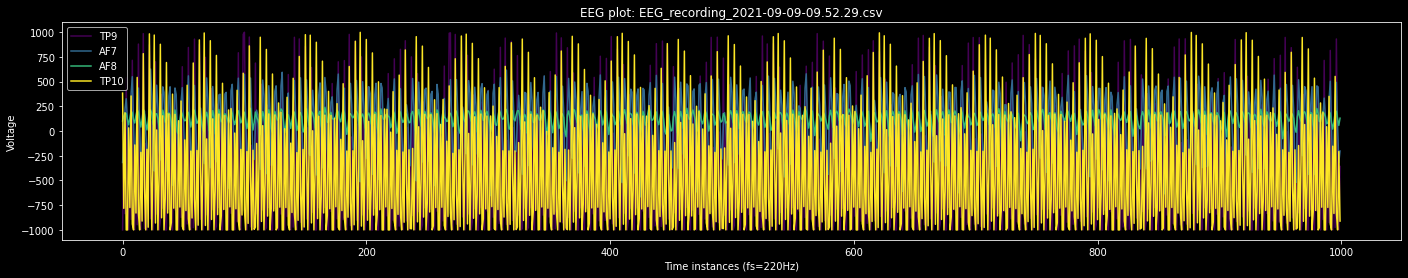

In [8]:
plot_EEGs(train_dataset.exp_eeg_list, train_dataset.electrodes, save_path, 
          train_dataset.samp_rate, file_names, experiment=0, file_name='EEG_plot', fig_sz=(24,4))

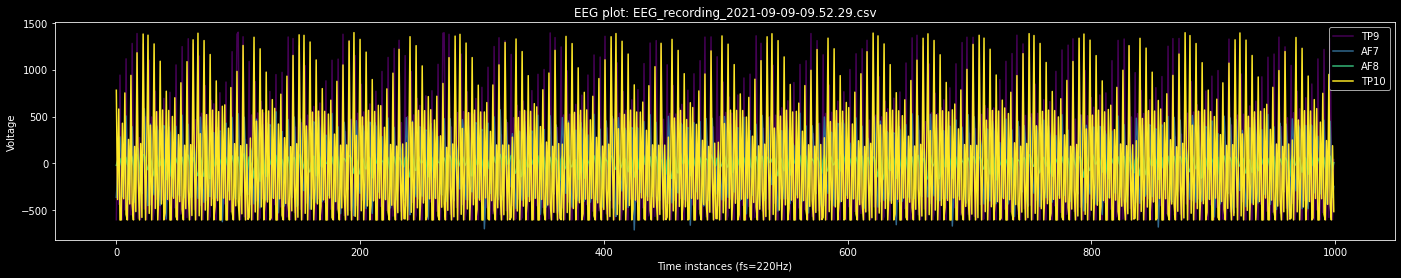

In [9]:
plot_EEGs(train_dataset.smooth_exp_list, train_dataset.electrodes, save_path, 
          train_dataset.samp_rate, file_names, experiment=0, file_name='smooth_eeg_plot', fig_sz=(24,4))

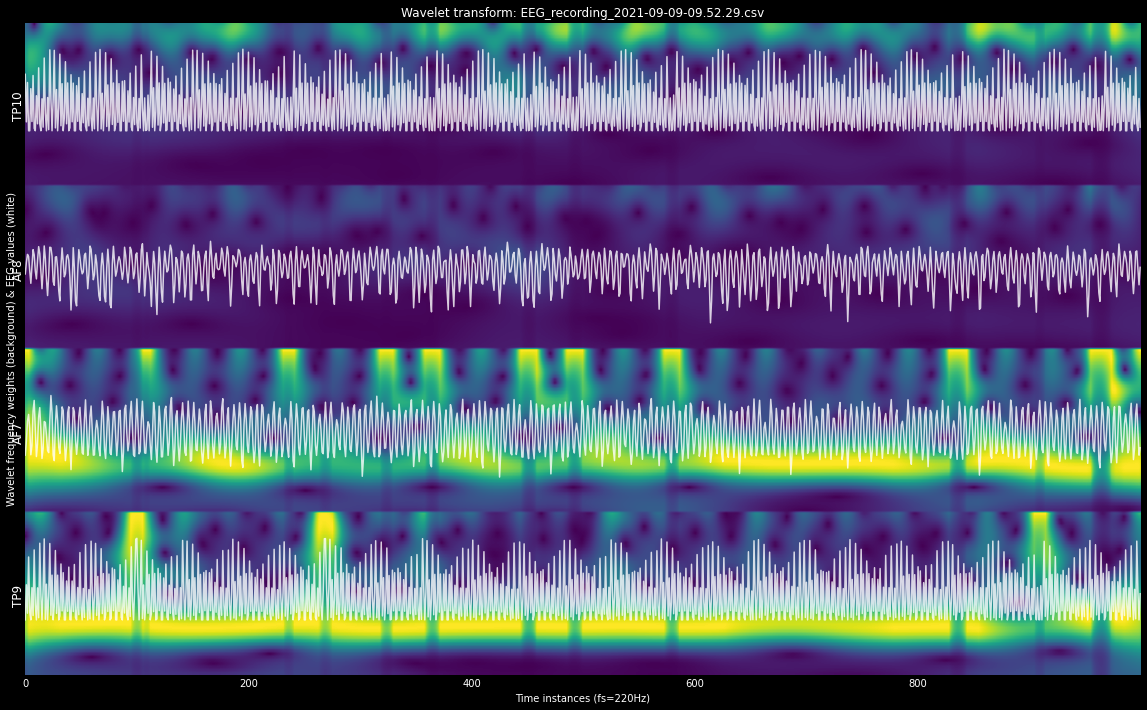

In [10]:
plot_wavelets(train_dataset.wav_exp_list, train_dataset.exp_eeg_list, file_names, train_dataset.electrodes, 
              train_dataset.num_channels, train_dataset.samp_rate, save_path, experiment=0, fig_sz=(20,12))

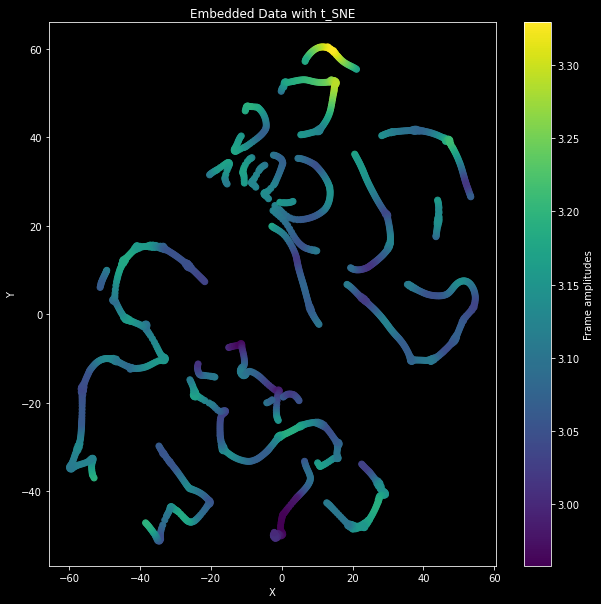

In [11]:
plot_embedding2D(data_embed, train_dataset.frame_amplitudes, save_path, file_names, low_dim.embed_algs, 
                 low_dim.technique, file_name='embed_plot', size=None, fig_sz=(10,10))